## EDA 

Data exploration for better understadning and formulation of the problem.

In [100]:
import pandas as pd
import numpy as np
import matplotlib as plt


# Data splitting
from sklearn.model_selection import train_test_split

# Creating a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.core.display import display, HTML
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pickle

In [101]:
dataset = pd.read_csv('movies.csv')
dataset.head(2)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
0,Avatar: The Way of Water,7.8,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",New Zealand,"$350,000,000","$2,267,946,983",United States
1,Guillermo del Toro's Pinocchio,7.6,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Bu...","Animation, Drama, Family",USA,"$35,000,000","$108,967","United States, Mexico, France"


In [102]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2000 non-null   object 
 1   Rating             1999 non-null   float64
 2   Year               2000 non-null   int64  
 3   Month              2000 non-null   object 
 4   Certificate        1966 non-null   object 
 5   Runtime            2000 non-null   object 
 6   Directors          2000 non-null   object 
 7   Stars              2000 non-null   object 
 8   Genre              2000 non-null   object 
 9   Filming_location   2000 non-null   object 
 10  Budget             2000 non-null   object 
 11  Income             2000 non-null   object 
 12  Country_of_origin  2000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 203.2+ KB


In [103]:
# Removing all rows that are missing at least one value
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1965 non-null   object 
 1   Rating             1965 non-null   float64
 2   Year               1965 non-null   int64  
 3   Month              1965 non-null   object 
 4   Certificate        1965 non-null   object 
 5   Runtime            1965 non-null   object 
 6   Directors          1965 non-null   object 
 7   Stars              1965 non-null   object 
 8   Genre              1965 non-null   object 
 9   Filming_location   1965 non-null   object 
 10  Budget             1965 non-null   object 
 11  Income             1965 non-null   object 
 12  Country_of_origin  1965 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 214.9+ KB


In [104]:
# Removing irrelevant columns
dataset = dataset.drop(['Certificate', 'Filming_location'], axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1965 non-null   object 
 1   Rating             1965 non-null   float64
 2   Year               1965 non-null   int64  
 3   Month              1965 non-null   object 
 4   Runtime            1965 non-null   object 
 5   Directors          1965 non-null   object 
 6   Stars              1965 non-null   object 
 7   Genre              1965 non-null   object 
 8   Budget             1965 non-null   object 
 9   Income             1965 non-null   object 
 10  Country_of_origin  1965 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 184.2+ KB


### Turning 'Month' column from str to int

In [105]:
# Checking how many unique values there are for column Month
month_values = dataset['Month'].unique()
odd_values = dataset['Month'].value_counts()['2008']

print(f'Unique values: {month_values}')
print(f'Number of times 2008 appears: {odd_values}')

Unique values: ['December' 'August' 'November' 'October' 'March' 'September' 'May'
 'April' 'January' 'July' 'June' 'February' '2008']
Number of times 2008 appears: 1


In [106]:
# 1. Drop the 2008 containing row
dataset = dataset.drop(dataset[dataset['Month'] == '2008'].index)

# 2. Maping names to integers
month_map = {
    'January': 1, 
    'February': 2, 
    'March': 3, 
    'April': 4, 
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# 3. Replacing the names (str) with integers
dataset['Month'] = dataset['Month'].replace(month_map)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1964 non-null   object 
 1   Rating             1964 non-null   float64
 2   Year               1964 non-null   int64  
 3   Month              1964 non-null   int64  
 4   Runtime            1964 non-null   object 
 5   Directors          1964 non-null   object 
 6   Stars              1964 non-null   object 
 7   Genre              1964 non-null   object 
 8   Budget             1964 non-null   object 
 9   Income             1964 non-null   object 
 10  Country_of_origin  1964 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 184.1+ KB


### Turning 'Runtime' column into int

In [107]:
# Checking for non-numerical values
print(dataset['Runtime'].unique())

# Converting to int values
dataset['Runtime'] = dataset['Runtime'].astype(int)

['192' '117' '127' '114' '102' '132' '134' '112' '151' '107' '188' '105'
 '131' '125' '126' '98' '101' '161' '140' '147' '139' '97' '154' '123'
 '130' '115' '176' '87' '129' '104' '99' '93' '137' '128' '100' '148'
 '158' '96' '86' '108' '89' '103' '135' '119' '136' '77' '118' '138' '159'
 '122' '187' '146' '121' '116' '167' '141' '92' '155' '163' '106' '133'
 '88' '110' '150' '156' '242' '109' '124' '143' '111' '152' '120' '90'
 '113' '144' '179' '142' '91' '95' '160' '94' '85' '83' '181' '209' '169'
 '84' '149' '78' '75' '164' '145' '82' '168' '165' '153' '180' '157' '172'
 '80' '162' '170' '79' '166' '81' '191' '71' '175' '201' '178']


### Turning Budget and Income values into int with a common currency (USD)

In [108]:
# Checking for non-numerical values
budget_values = dataset['Budget'].unique()
income_values = dataset['Income'].unique()

print(f'Budget values: {budget_values}')
print(f'Income values: {income_values}')

Budget values: ['$350,000,000 ' '$35,000,000 ' '$85,900,000 ' 'Unknown' '$12,000,000 '
 '$120,000,000 ' '$80,000,000 ' '$20,000,000 ' '$10,000,000 '
 '$40,000,000 ' '$78,000,000 ' '$1,000,000 ' '$16,000,000 '
 '$195,000,000 ' '$100,000,000 ' '$250,000,000 ' '€ 10,000,000'
 '$25,000,000 ' '$3,000,000 ' '$150,000,000 ' '$170,000,000 '
 '$17,000,000 ' '$200,000,000 ' '$4,500,000 ' '$32,000,000 '
 '$60,000,000 ' '$72,000,000 ' '$68,000,000 ' '$24,000,000 '
 '$50,000,000 ' '$90,000,000 ' '$250,000 ' '$85,000,000 ' '$8,000,000 '
 '₹3,500,000,000' '$22,000,000 ' '$165,000,000 ' '$30,000,000 '
 '$185,000,000 ' '$75,000,000 ' '$18,000,000 ' '$55,000,000 '
 '$43,000,000 ' '€ 5,000,000' '$300,000,000 ' 'SEK\xa019,000,000'
 '$190,000,000 ' '$15,000,000 ' '$160,000,000 ' '$70,000,000 '
 '$24,350,000 ' '$820,000 ' '$110,000,000 ' '$1,100,000 ' '€ 5,700,000'
 '$39,000,000 ' '$205,000,000 ' '$6,000,000 ' '$65,000,000 '
 '€ 14,000,000' '$14,000,000 ' '$84,500,000 ' '$45,000,000 '
 '$67,000,000 ' '$5,00

In [109]:
# Conversion function (converts currency and to float)
def convert_to_usd(amount):
    amount.replace(' ', '')
    amount.replace('\xa0', '')
    if amount.startswith('$'):
        amount = amount.strip('$').replace(',', '')   # must remove commas
        return float(amount)   # convert str into float
    elif amount.startswith('€'):
        # Exchange rate for EUR to USD
        amount = amount.strip('€').replace(',', '')
        return float(amount) * 1.06 
    elif amount.startswith('¥'):
        # Exchange rate for YEN to USD
        amount = amount.strip('¥').replace(',', '')
        return float(amount) * 0.0075
    elif amount.startswith('₹'):
        # Exchange rate for RPL to USD
        amount = amount.strip('₹').replace(',', '')
        return float(amount) * 0.012 
    elif amount.startswith('SEK'):
        # Exchange rate for SEK to USD
        amount = amount.strip('SEK').replace(',', '')
        return float(amount) * 0.094
    elif amount.startswith('DKK'):
        # Exchange rate for RPL to USD
        amount = amount.strip('DKK').replace(',', '')
        return float(amount) * 0.14
    elif amount.startswith('£'):
        # Exchange rate for RPL to USD
        amount = amount.strip('£').replace(',', '')
        return float(amount) * 1.21  
    else:
        return None

In [110]:
# Applying the conversion functino to the 'Budget' column
dataset['Budget'] = dataset['Budget'].apply(convert_to_usd)
dataset['Income'] = dataset['Income'].apply(convert_to_usd)

print(dataset['Budget'].isnull().sum())  # 292 missing values
print(dataset['Income'].isnull().sum())  # 126 missing values

292
126


Given the number of missing values in the two columns above, at least 292 values will be dropped about 15% of the original data. Therefore, new dataset is created to have access to two different datasets:
1. dataset_w_finances - budget and income columns are kept, but all movies lacking one of these values have been removed.
2. dataset_wo_finances - budget and income columns are removed for all movies.

In [111]:
dataset_w_finances = dataset.dropna(subset=['Budget', 'Income'])
dataset_wo_finances = dataset.drop(['Budget', 'Income'], axis=1)

### Turning Genre into int table

Since one movie can belong to several genr

In [112]:
# 1. Isolate the genre column as a pivot table

genre_list = []
for genres in dataset_w_finances['Genre']:
    genre_list.append(genres.split(', '))

unique_g= set()
for genres in genre_list:
    for genre in genres:
        unique_g.add(genre)

unique_genres = list(unique_g)
print(f'Possinle genres: {unique_genres}')

genre_subtable = pd.DataFrame(columns=['Title'] + unique_genres)

# genre_subtable = pd.concat(
#     [genre_subtable, pd.DataFrame(new_row, index=[0])], 
#     ignore_index=True
# )

for i, row in dataset_w_finances.iterrows():
    new_row = {'Title': row['Title']}
    for genre in unique_genres:
        new_row[genre] = 0
    for genre in row['Genre'].split(', '):
        new_row[genre] = 1
    genre_subtable = genre_subtable.append(new_row, ignore_index=True)


Possinle genres: ['Family', 'Music', 'Musical', 'Mystery', 'Drama', 'Sci-Fi', 'Animation', 'Thriller', 'Biography', 'Crime', 'War', 'Western', 'Action', 'Sport', 'History', 'Romance', 'Adventure', 'Comedy', 'Horror', 'Fantasy']


In [113]:
pivot_table = genre_subtable.melt(id_vars='Title', var_name='Genre')
pivot_table = pivot_table[pivot_table['value'] == 1]
pivot_table = pivot_table.drop(columns=['value'])
pivot_table = pivot_table.pivot_table(index='Title', columns='Genre', aggfunc='size', fill_value=0).reset_index()

# Merge the pivot table with the original DataFrame
dataset_w_finances = pd.merge(dataset_w_finances, pivot_table, on='Title', how='left')
dataset_w_finances.drop(columns=['Genre'], inplace=True)

In [114]:
print(dataset_w_finances.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636 entries, 0 to 1635
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1636 non-null   object 
 1   Rating             1636 non-null   float64
 2   Year               1636 non-null   int64  
 3   Month              1636 non-null   int64  
 4   Runtime            1636 non-null   int64  
 5   Directors          1636 non-null   object 
 6   Stars              1636 non-null   object 
 7   Budget             1636 non-null   float64
 8   Income             1636 non-null   float64
 9   Country_of_origin  1636 non-null   object 
 10  Action             1636 non-null   int64  
 11  Adventure          1636 non-null   int64  
 12  Animation          1636 non-null   int64  
 13  Biography          1636 non-null   int64  
 14  Comedy             1636 non-null   int64  
 15  Crime              1636 non-null   int64  
 16  Drama              1636 

In [115]:
dataset_w_finances['Lead'] = dataset_w_finances['Stars'].fillna('').str.split(',', expand=True)[0]
dataset_w_finances['Supporting'] = dataset_w_finances['Stars'].fillna('').str.split(',', expand=True)[1]
dataset_w_finances.drop(columns=['Stars'], inplace=True)

In [116]:
dataset_w_finances

,Title,Rating,Year,Month,Runtime,Directors,Budget,Income,Country_of_origin,Action,...,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Lead,Supporting
0,Avatar: The Way of Water,7.8,2022,12,192,James Cameron,350000000.0,2.267947e+09,United States,1,...,0,0,0,0,0,0,0,0,Sam Worthington,Zoe Saldana
1,Guillermo del Toro's Pinocchio,7.6,2022,12,117,"Guillermo del Toro, Mark Gustafson",35000000.0,1.089670e+05,"United States, Mexico, France",0,...,0,0,0,0,0,0,0,0,Ewan McGregor,David Bradley
2,Bullet Train,7.3,2022,8,127,David Leitch,85900000.0,2.392686e+08,"Japan, United States",1,...,0,0,0,0,0,1,0,0,Brad Pitt,Joey King
3,M3gan,6.4,2022,12,102,Gerard Johnstone,12000000.0,1.712539e+08,United States,0,...,0,0,0,1,0,1,0,0,Jenna Davis,Amie Donald
4,Amsterdam,6.1,2022,10,134,David O Russell,80000000.0,3.124581e+07,"United States, Japan",0,...,0,0,0,0,0,0,0,0,Christian Bale,Margot Robbie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,House of Sand and Fog,7.5,2003,1,126,Vadim Perelman,16500000.0,1.676380e+07,United States,0,...,0,0,0,0,0,0,0,0,Jennifer Connelly,Ben Kingsley
1632,In the Cut,5.4,2003,10,119,Jane Campion,12000000.0,2.372679e+07,"United Kingdom, Australia, France, United States",0,...,0,1,0,0,0,1,0,0,Meg Ryan,Mark Ruffalo
1633,Lara Croft Tomb Raider: The Cradle of Life,5.5,2003,7,117,Jan de Bont,95000000.0,1.600992e+08,"United States, Germany, Japan, United Kingdom,...",1,...,0,0,0,0,0,0,0,0,Angelina Jolie,Gerard Butler
1634,Gothika,5.8,2003,11,98,Mathieu Kassovitz,40000000.0,1.415913e+08,"United States, France, Canada, Spain",0,...,0,1,0,0,0,1,0,0,Halle Berry,Pen lope Cruz


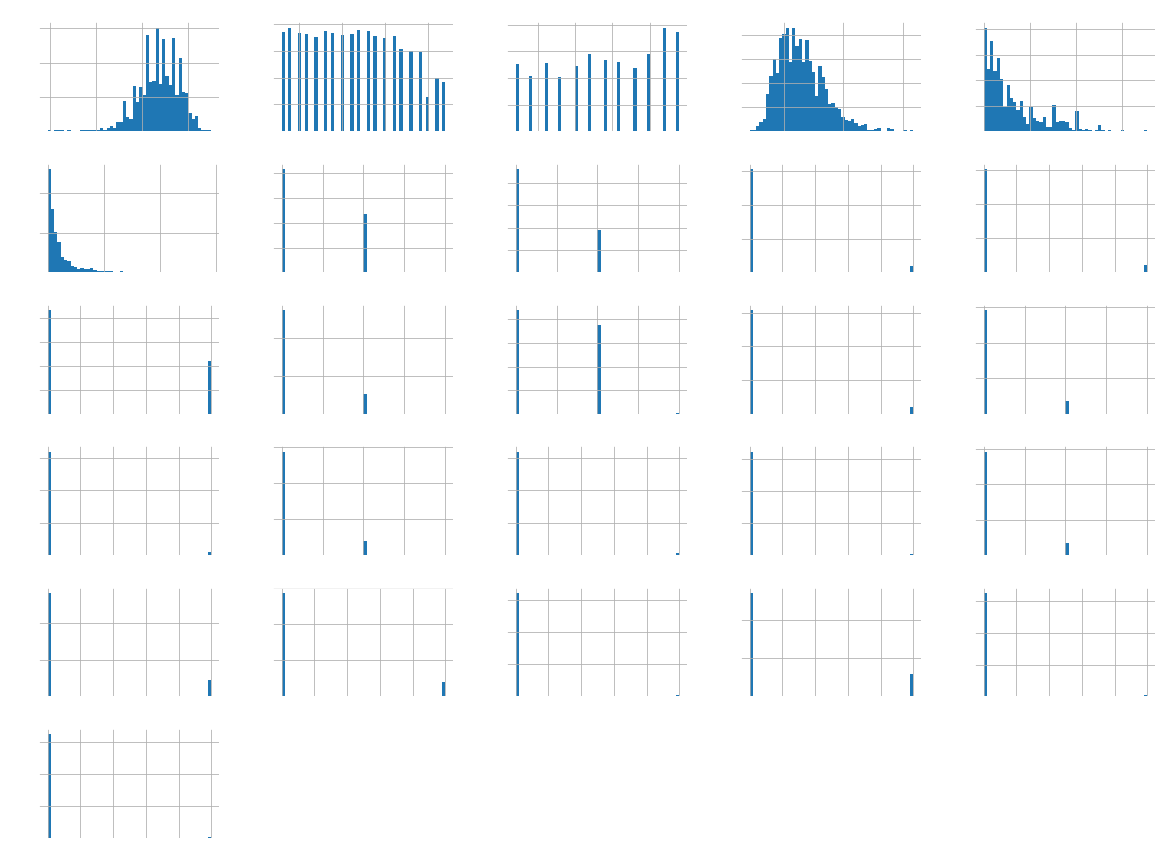

In [117]:
params = {'ytick.color' : 'w',
          'xtick.color' : 'w',
          'axes.labelcolor' : 'w',
          'axes.edgecolor' : 'w', 
          'text.color': 'w'}
plt.rcParams.update(params)

dataset_w_finances.hist(bins=50, figsize=(20, 15))
plt.show()

array([[<AxesSubplot: xlabel='Rating', ylabel='Rating'>,
        <AxesSubplot: xlabel='Year', ylabel='Rating'>,
        <AxesSubplot: xlabel='Budget', ylabel='Rating'>,
        <AxesSubplot: xlabel='Income', ylabel='Rating'>],
       [<AxesSubplot: xlabel='Rating', ylabel='Year'>,
        <AxesSubplot: xlabel='Year', ylabel='Year'>,
        <AxesSubplot: xlabel='Budget', ylabel='Year'>,
        <AxesSubplot: xlabel='Income', ylabel='Year'>],
       [<AxesSubplot: xlabel='Rating', ylabel='Budget'>,
        <AxesSubplot: xlabel='Year', ylabel='Budget'>,
        <AxesSubplot: xlabel='Budget', ylabel='Budget'>,
        <AxesSubplot: xlabel='Income', ylabel='Budget'>],
       [<AxesSubplot: xlabel='Rating', ylabel='Income'>,
        <AxesSubplot: xlabel='Year', ylabel='Income'>,
        <AxesSubplot: xlabel='Budget', ylabel='Income'>,
        <AxesSubplot: xlabel='Income', ylabel='Income'>]], dtype=object)

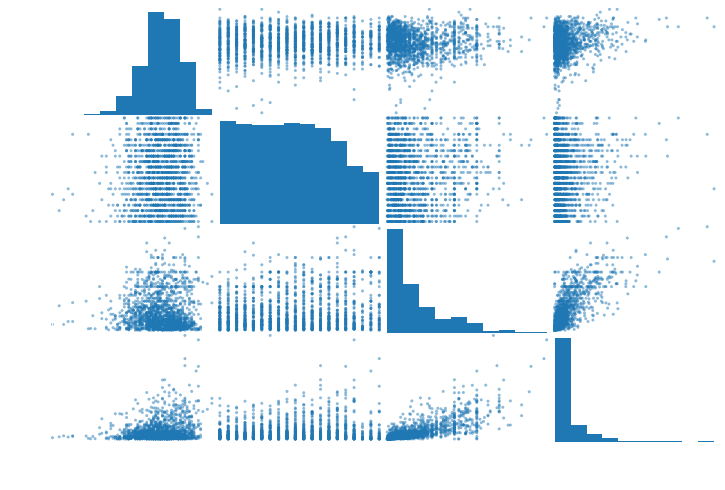

In [118]:
from pandas.plotting import scatter_matrix

attributes = ['Rating', 'Year', 'Budget', 'Income']
scatter_matrix(dataset_w_finances[attributes], figsize=(12, 8))

In [119]:
print(dataset_w_finances.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636 entries, 0 to 1635
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1636 non-null   object 
 1   Rating             1636 non-null   float64
 2   Year               1636 non-null   int64  
 3   Month              1636 non-null   int64  
 4   Runtime            1636 non-null   int64  
 5   Directors          1636 non-null   object 
 6   Budget             1636 non-null   float64
 7   Income             1636 non-null   float64
 8   Country_of_origin  1636 non-null   object 
 9   Action             1636 non-null   int64  
 10  Adventure          1636 non-null   int64  
 11  Animation          1636 non-null   int64  
 12  Biography          1636 non-null   int64  
 13  Comedy             1636 non-null   int64  
 14  Crime              1636 non-null   int64  
 15  Drama              1636 non-null   int64  
 16  Family             1636 

<AxesSubplot: >

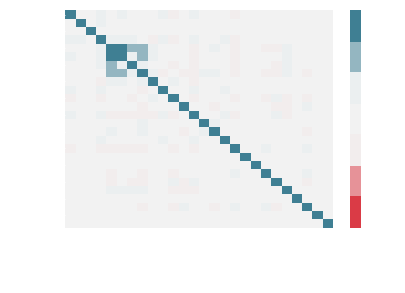

In [120]:
import seaborn as sns

sns.heatmap(dataset_w_finances.drop(['Directors', 'Lead', 'Supporting'], axis=1).corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(10, 220, sep=80, n=7))

In [121]:
dataset_w_finances = dataset_w_finances.drop(['Directors', 'Lead', 'Supporting', 'Country_of_origin'], axis=1)
print(dataset_w_finances.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1636 entries, 0 to 1635
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      1636 non-null   object 
 1   Rating     1636 non-null   float64
 2   Year       1636 non-null   int64  
 3   Month      1636 non-null   int64  
 4   Runtime    1636 non-null   int64  
 5   Budget     1636 non-null   float64
 6   Income     1636 non-null   float64
 7   Action     1636 non-null   int64  
 8   Adventure  1636 non-null   int64  
 9   Animation  1636 non-null   int64  
 10  Biography  1636 non-null   int64  
 11  Comedy     1636 non-null   int64  
 12  Crime      1636 non-null   int64  
 13  Drama      1636 non-null   int64  
 14  Family     1636 non-null   int64  
 15  Fantasy    1636 non-null   int64  
 16  History    1636 non-null   int64  
 17  Horror     1636 non-null   int64  
 18  Music      1636 non-null   int64  
 19  Musical    1636 non-null   int64  
 20  Mystery 

In [122]:
import numpy as np

criteria = [dataset_w_finances['Rating'].between(0, 4), dataset_w_finances['Rating'].between(4, 7), dataset_w_finances['Rating'].between(7, 10)]
values = [1, 2, 3]

dataset_w_finances['Target'] = np.select(criteria, values, 0)
dataset_w_finances.tail()
dataset_w_finances = dataset_w_finances.drop('Rating',axis=1)

In [123]:
X, y = dataset_w_finances.iloc[:,1:], dataset_w_finances['Target']
cols = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20)

In [124]:
KNN = KNeighborsClassifier()
Extra = ExtraTreesClassifier()
GD = GradientBoostingClassifier()

In [128]:
KNN.fit(X_train, y_train)
knn = KNN.score(X_test, y_test)
print(f'KNN: ', knn*100)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
y_pred_mean = [y_train.mean()] * len(y_test)

print("Baseline score RMSE: ",'{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))))